## Import Libs and DS

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random

df = pd.read_csv('marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [7]:
df = df.drop(columns=['Unnamed: 0'], axis=1) # drop unnamed col as we don't use it

df.rename(columns = lambda x: x.strip().replace(' ', '_'), inplace=True) # Remove white space in col names and add underscores

df['converted_int'] = df['converted'].apply(lambda x:1 if x==True else 0) # Turn converted feature into numerical

print('any duplicate rows?', df.duplicated().any())
print('any duplicate users? ', df['user_id'].duplicated().any())

any duplicate rows? False
any duplicate users?  False


## EDA

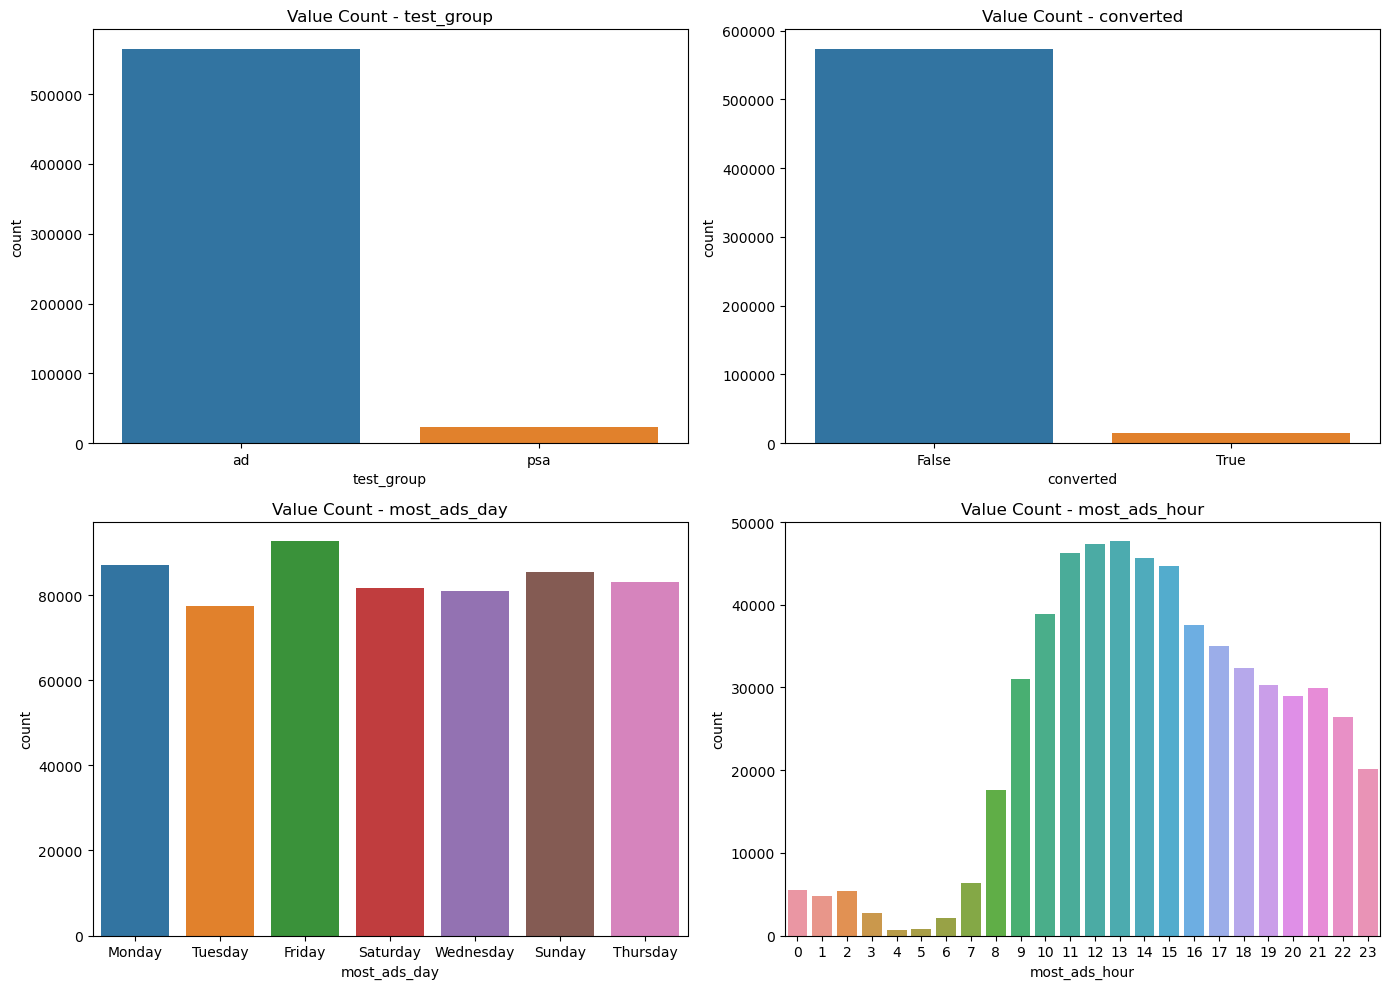

In [8]:
def val_count(df, cols):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # Create a 2x2 grid of subplots
    axs = axs.flatten()  # Flatten the 2D array of axes for easy iterating
    
    for col, ax in zip(cols, axs): # Iterate over the columns and corresponding axes
        sns.countplot(data=df, x=col, ax=ax)
        ax.set_title(f'Value Count - {col}')
    plt.tight_layout()
    plt.show()

cols = ['test_group', 'converted', 'most_ads_day', 'most_ads_hour']
val_count(df, cols)

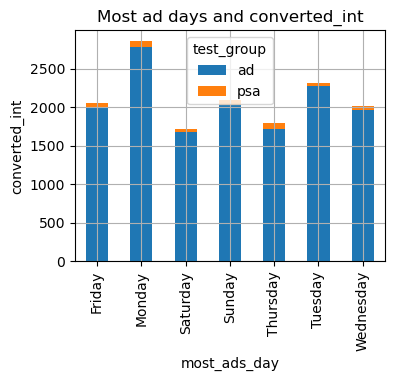

In [11]:
grouped_data = df.groupby(['most_ads_day', 'test_group']).sum()['converted_int'].unstack('test_group')
# Plotting
ax = grouped_data.plot(kind='bar', figsize=(4, 3), grid=True, stacked=True)
ax.set_ylabel('converted_int')
ax.set_title('Most ad days and converted_int')
plt.show()

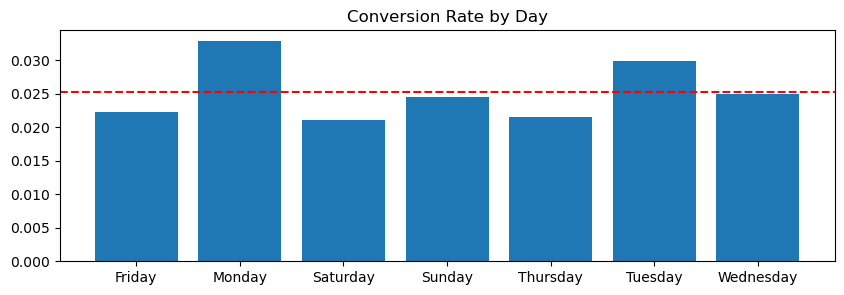

In [12]:
avg_cv_day = pd.DataFrame(df.groupby('most_ads_day').mean(numeric_only=True)['converted']).reset_index()

plt.figure(figsize=(10,3))
plt.bar(data=avg_cv_day, x='most_ads_day', height='converted')
plt.title('Conversion Rate by Day')
plt.axhline(df['converted'].mean(), color='r', linestyle='--', label='average')
plt.show()

determine the minimum number of respondents or observations you need to have a certain level of confidence that your sample accurately represents the population, within a specified margin of error.

# -------------------------------------------------------------------------------------

# Permutation AB Testing

In [13]:
np.random.seed(123)

In [14]:
treatment = df[df['test_group'] == 'ad'] 
print('when shown ads: ', treatment['converted'].mean()*100)

control = df[df['test_group'] == 'psa'] 
print('when shown psa: ', control['converted'].mean()*100)

when shown ads:  2.5546559636683748
when shown psa:  1.785410644448223


### Permutation Test
* Notice we are using the same df.converted.mean() as the chance of success for ad_converted and psa_converted?
* Reason is that the we are constructing the Null Hypothesis
* Using same conversion rate, we model a reality where null hypothesis is True
* Having same conversion rate means treatment has no effect compared to control

In [15]:
#Distribution of ad converted
sim_ad_converted = np.random.binomial(len(treatment), #564577
                                  df.converted.mean(), #0.02523886203220195
                                  10000) / len(treatment)

#distriution of psa converted
sim_psa_converted = np.random.binomial(len(control), #23524
                                   df.converted.mean(), #0.02523886203220195
                                   10000) / len(control)
print(sim_ad_converted.mean())
print(sim_psa_converted.mean())

0.02523872757834627
0.025233047100833194


In [16]:
#diff between Distribution of ad converted & #distriution of psa converted
sim_diffs = sim_ad_converted - sim_psa_converted 

#diff between actual treatment conversion vs controlled conversion
actual_diff = treatment['converted'].mean() - control['converted'].mean() #Array of differences in actual set


### How many of the simulated differences are bigger than the actual difference in mean?
### What is our P value

In [17]:
(sim_diffs > actual_diff).mean()
print('reject null hypothesis, implement ad, it is statistically significant')

reject null hypothesis, implement ad, it is statistically significant


Comparing the simulated differences and the actual difference, we want to see the percentage of the estimated differences that are bigger or smaller than the actual difference.

If there less than 5% of the simulated differences > actual difference, it means to observe this difference is quite rare, so the fact that the actual dataset was able to observe this concludes it is a significant result

If there is more than 5% chance of the simulated differences > actual difference, it the actual difference could be attributed to randomness, therefore we shouldn't implement the change

# -------------------------------------------------------------------------------------

# T - Test

### First we calculate the mean conversion rate of the treatment group and the control group

In [36]:
treatment_mean = df[df['test_group'] == 'ad']['converted'].mean()
control_mean = df[df['test_group'] == 'psa']['converted'].mean()

print('treatment mean conversion rate=',treatment_mean)
print('control mean conversion rate=',control_mean)

treatment mean conversion rate= 0.025546559636683747
control mean conversion rate= 0.01785410644448223


### BootStrap a distribution for treatment group

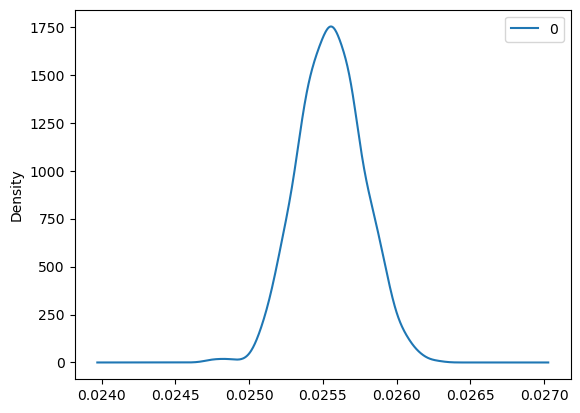

In [59]:
# Randomly take 567577 samples from treatment, takes the mean of it, adds the mean into a list
# The above process repeated 1000 times

boot_treatment = []

for i in range(1000):
    
    # Sampling frac=1 which is randomly selecting 564577 values from converted
    # Replace = True means each sample draw is independent from the prev
    boot_mean = treatment.sample(frac=1, replace=True)['converted'].mean()
    boot_treatment.append(boot_mean)
    
boot_treatment = pd.DataFrame(boot_treatment)

# Plotting the distribution of these bootstrapped means
boot_treatment.plot(kind='density');

### Bootstrap a distribution for control group

<Axes: ylabel='Density'>

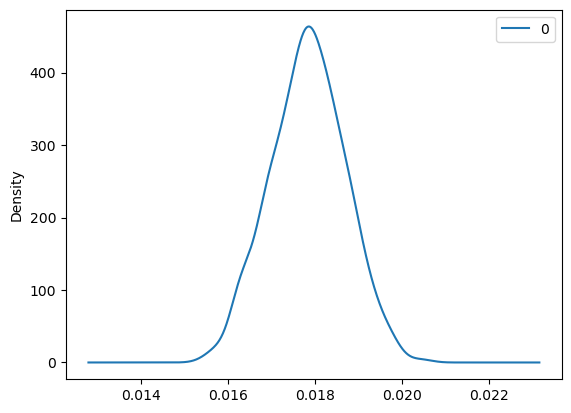

In [76]:
boot_control = []

for i in range(1000):
    boot_mean = control.sample(frac=1, replace=True)['converted'].mean()
    boot_control.append(boot_mean)

boot_control = pd.DataFrame(boot_control)

boot_control.plot(kind='density')

### Why Bootstrap when we can just run a T-test already?

 If the bootstrapped means are normally distributed and the two distributions do not overlap much, this suggests that a t-test would likely find a significant difference between the groups. Conversely, if there is a lot of overlap, this could indicate that any observed difference in means might not be statistically significant.

In [95]:
print('treatment group variance',treatment['converted'].var())
print('control group variance',control['converted'].var())
print('gen rule is largest sample cannot be 4x larger than smaller samples var')
print('in this case, we can use normal t test instead of welch t test')

treatment group variance 0.024893977020560756
control group variance 0.01753608278252422
gen rule is largest sample cannot be 4x larger than smaller samples var
in this case, we can use normal t test instead of welch t test


In [96]:
stats.ttest_ind(treatment['converted'], control['converted'], equal_var=True)[1]

1.7033052627831264e-13